In [2]:
import numpy as np
import pandas as pd
import json
import os

## Load latest full error

In [3]:
full_err_df = pd.read_csv("Full/full_err.csv", index_col=0)

## Error Tests

### Test 1: train test split base (mae)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import HuberRegressor

# Features and target
X = full_err_df[['N', 'theta', 'dt', 'I']]
y = full_err_df['accumulated_error']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model: Random Forest Regressor
# model = RandomForestRegressor(n_estimators=100, random_state=42)
model = HuberRegressor()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.6f}")

# Example Prediction for an arbitrary input
example_input = {'N': 100, 'theta': 0.2, 'dt': 6.25e-05, 'I': 5000}
example_scaled = scaler.transform(pd.DataFrame([example_input]))
predicted_error = model.predict(example_scaled)
print(f"Predicted Accumulated Energy Error: {predicted_error[0]:.6f}")

Mean Absolute Error: 8183.134219
Predicted Accumulated Energy Error: -779.361373


### Test 2: Feature subset CV starting tests

In [ ]:
from sklearn.linear_model import HuberRegressor

# Define dataset and parameters
input_features = ['N', 'theta', 'dt', 'I']
target_feature = 'accumulated_error'

# Define the model pipeline
pipeline = Pipeline(steps=[
    # ('normalize', QuantileTransformer()),
    ('model', HuberRegressor())
])

# Wrap with TransformedTargetRegressor
model = TransformedTargetRegressor(
    regressor=pipeline, 
    transformer=FunctionTransformer(lambda x:x)
)

# Define hyperparameter grid
model_params = {
    'regressor__model__epsilon': [1.35, 1.5, 1.75],
    'regressor__model__alpha': [0.0001, 0.001, 0.01],
}

# Run feature subset evaluation using Random CV
best_result_hr, res_hr = run_feature_subset_cv(
    f_full=full_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=model,
    model_params=model_params,
    use_feature_subsets=False,
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_hr['features'])
print("Best parameters:", best_result_hr['best_params'])
print("Best MAE:", best_result_hr['best_mae'])
print("Best MAPE:", best_result_hr['best_mape'])

# # Run feature subset evaluation using GPU split CV
# best_result_hr, res_hr = run_feature_subset_cv(
#     f_full=f_full,
#     input_features=input_features,
#     target_feature=target_feature,
#     model=model,
#     model_params=model_params,
#     use_feature_subsets=True,
#     use_gpu_cv=True  # Set to False to use regular KFold
# )

# # Display the best result
# print("Best feature subset:", best_result_hr['features'])
# print("Best parameters:", best_result_hr['best_params'])
# print("Best MAE:", best_result_hr['best_mae'])
# print("Best MAPE:", best_result_hr['best_mape'])


### Test 3: Feature subset CV with sampling (mae)

In [ ]:
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures

base_model_poly = Pipeline([
                    ('poly', PolynomialFeatures(5)),   # PolynomialFeatures step
                    ('ridge', Ridge())                # Ridge regression step
                ])

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import HuberRegressor

# Features and target
X = sampled_err_df[['N', 'theta', 'dt', 'I']]
y = sampled_err_df['accumulated_error']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Feature scaling
scaler = FunctionTransformer(lambda x:x**1/10)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model: Random Forest Regressor
# model = RandomForestRegressor(n_estimators=100, random_state=42)
model = base_model_poly
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.6f}")

# Example Prediction for an arbitrary input
example_input = {'N': 1000000, 'theta': 0.2, 'dt': 0.00625, 'I': 5000}
example_scaled = scaler.transform(pd.DataFrame([example_input]))
predicted_error = model.predict(example_scaled)
print(f"Predicted Accumulated Energy Error: {predicted_error[0]:.6f}")

# Cross validation training

### Wrapped Cross Validation Grid Search Trainer

In [8]:
from numpy import mean, absolute
from itertools import combinations
from sklearn.model_selection import KFold, GroupKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_percentage_error
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter
from IPython.display import clear_output
import os

def run_feature_subset_cv(
    f_full, 
    input_features, 
    target_feature, 
    model, 
    model_params, 
    extra_features=[], 
    use_gpu_cv=False,
    use_feature_subsets=True, 
    refit_error='MAPE', #MAPE OR MAE
    output_folder="CV_results"
):
    
    # Prepare input and target
    X_full = f_full[input_features+extra_features]
    y = f_full[target_feature]
    groups = f_full['Name'] if use_gpu_cv else None  # Use 'Name' for GroupKFold if applicable

    # Generate feature subsets or use all features
    if use_feature_subsets:
        feature_subsets = []
        for r in range(1, len(X_full[input_features].columns) + 1):  # r = subset size (1 to len(columns))
            feature_subsets.extend(combinations(X_full[input_features].columns, r))
    else:
        feature_subsets = [input_features]  # Use all input features as one subset
    
    # Define cross-validation strategy
    cv = GroupKFold(n_splits=5) if use_gpu_cv else KFold(n_splits=10, shuffle=True, random_state=1)

    # Define scoring metrics
    scorer_mae = make_scorer(mean_absolute_error, greater_is_better=False)
    scorer_mape = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

    # Store results
    results = []

    print(f"Testing {len(feature_subsets)} feature subset(s)...")
    with tqdm(total=len(feature_subsets), desc="Progress", unit="subset") as pbar, \
         tqdm(total=len(feature_subsets), desc="Custom Text", unit="update") as text_pbar:
                # Iterate over feature subsets
        for features in feature_subsets:
            # Subset the input data
            X = X_full[list(features)+extra_features]

            # Create GridSearchCV object
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=model_params,
                scoring={'MAE': scorer_mae, 'MAPE': scorer_mape},
                refit=refit_error,  # Optimize based on MAPE
                cv=cv.split(X, y, groups) if use_gpu_cv else cv,
                verbose=0,
                n_jobs=-1  # Use all available cores
            )

            # Fit GridSearchCV
            grid_search.fit(X, y)

            # Append results
            results.append({
                'features': list(features)+extra_features,
                'best_params': grid_search.best_params_,
                'best_mae': -grid_search.cv_results_['mean_test_MAE'][grid_search.best_index_],
                'best_mape': -grid_search.cv_results_['mean_test_MAPE'][grid_search.best_index_]
            })
            
            pbar.set_postfix({"current_subset": str(list(features)+extra_features), "current_mae": round(results[-1]['best_mae'], 3),"current_mape": round(results[-1]['best_mape'], 3)})
            text_pbar.set_description_str(
                f"> best_mae:{round(min(results, key=lambda x: x['best_mae'])['best_mae'], 3)}\n"+
                f"> best_mape:{round(min(results, key=lambda x: x['best_mape'])['best_mape'], 3)}\n"+
                f"> best_params:{min(results, key=lambda x: x['best_mape'])['best_params']}\n"+
                f"> best_features:{min(results, key=lambda x: x['best_mape'])['features']}")
            pbar.update(1)
            text_pbar.update(1)

    # Find the best result
    best_result = min(results, key=lambda x: x['best_mape'])
    
    # Extract the model name from the pipeline
    model_name = model.regressor.steps[-1][1].__class__.__name__

    # Determine CV type for the filename
    cv_type = "GPU_CV" if use_gpu_cv else "Random_CV"

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Construct the base filename
    base_filename = f"{model_name}_{cv_type}_results"
    output_path = os.path.join(output_folder, f"{base_filename}.json")

    # If a file with the same name exists, append a number
    counter = 1
    while os.path.exists(output_path):
        output_path = os.path.join(output_folder, f"{base_filename}_{counter}.json")
        counter += 1

    # Include best result in the JSON data
    output_data = {
        "all_results": results,
        "best_result": best_result
    }

    # Write results to a JSON file
    with open(output_path, 'w') as json_file:
        json.dump(output_data, json_file, indent=4, default=str)  # Use default=str for non-serializable data

    print(f"Results saved to {output_path}")
    
    return best_result,results


### Error dataset sampling (max 1000 by hardware)

In [6]:
# Sample by interval
interval = 1000  # Define the interval for I
sampled_err_df = full_err_df[full_err_df['I'] % interval == 0]  # Sample rows where I is a multiple of the interval\
print(full_err_df.shape)
print(sampled_err_df.shape)

(1000100, 5)
(1000, 5)


### Huber tests
* Best Random CV **(MAPE 14.54):** CV_results/error/HuberRegressor_Random_CV_results_64.json

In [ ]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer,FunctionTransformer,MinMaxScaler
from sklearn.linear_model import HuberRegressor


# Define dataset and parameters
input_features = ['N', 'theta', 'dt', 'I']
target_feature = 'accumulated_error'


# Define the model pipeline
pipeline = Pipeline(steps=[
    ('normalize', QuantileTransformer(n_quantiles=500)), # WORKS BETTER 
    ('model', HuberRegressor())
])

# Wrap with TransformedTargetRegressor
model_huber = TransformedTargetRegressor(
    regressor=pipeline, 
    transformer=QuantileTransformer(n_quantiles=500)
    # transformer=FunctionTransformer(lambda x:x)
)

# Define hyperparameter grid
model_params_huber = {
    'regressor__model__epsilon': [1,1.35, 1.5, 1.75, 2],
    'regressor__model__alpha': [0.00001,0.0001, 0.001, 0.01,0.1,1],
}

In [86]:
# Run feature subset evaluation using Random CV
best_result_huber, res_huber = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=model_huber,
    model_params=model_params_huber,
    output_folder="CV_results/error",
    use_feature_subsets=False,
    refit_error='MAPE',
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_huber['features'])
print("Best parameters:", best_result_huber['best_params'])
print("Best MAE:", best_result_huber['best_mae'])
print("Best MAPE:", best_result_huber['best_mape'])



Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error/HuberRegressor_Random_CV_results_64.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__alpha': 1e-05, 'regressor__model__epsilon': 2}
Best MAE: 7746.181007989227
Best MAPE: 14.540428183017344


### SVR tests
* Best Random CV **(MAPE 0.237):** CV_results/error/SVR_Random_CV_results_58.json

In [ ]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer,FunctionTransformer,MinMaxScaler
from sklearn.svm import SVR


# Define dataset and parameters
input_features = ['N', 'theta', 'dt', 'I']
target_feature = 'accumulated_error'

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('normalize', QuantileTransformer(n_quantiles=500)), # WORKS BETTER 
    ('model', SVR()) ## SECOND BEST AND NICE GENERALIZING!!!! C=100,epsilon=0.0001
])

# Wrap with TransformedTargetRegressor
model_svr = TransformedTargetRegressor(
    regressor=pipeline, 
    transformer=QuantileTransformer(n_quantiles=500)
)

# Define hyperparameter grid
model_params_svr = {
    'regressor__model__C': [0.0001,0.001, 0.01, 0.1, 1, 10, 50,100],
    'regressor__model__epsilon': [0.00001,0.0001, 0.001, 0.01, 0.1, 0.5, 1], 
    'regressor__model__kernel': ['rbf']
}


In [152]:
# Run feature subset evaluation using Random CV
best_result_svr, res_svr = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=model_svr,
    model_params=model_params_svr,
    output_folder="CV_results/error",
    use_feature_subsets=False,
    refit_error='MAPE',
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_svr['features'])
print("Best parameters:", best_result_svr['best_params'])
print("Best MAE:", best_result_svr['best_mae'])
print("Best MAPE:", best_result_svr['best_mape'])

Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error/SVR_Random_CV_results_59.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__C': 100, 'regressor__model__epsilon': 0.001, 'regressor__model__kernel': 'rbf'}
Best MAE: 851.0322638817663
Best MAPE: 0.2374874643382013


### DT tests
* Best Random CV **(MAPE 0.327):** CV_results/error/DecisionTreeRegressor_Random_CV_results_15.json

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import PowerTransformer, QuantileTransformer,FunctionTransformer,MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import HuberRegressor, Ridge
from sklearn.preprocessing import PolynomialFeatures


# Define dataset and parameters
input_features = ['N', 'theta', 'dt', 'I']
target_feature = 'accumulated_error'

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('normalize', QuantileTransformer(n_quantiles=500)), # WORKS BETTER 
    ('model', DecisionTreeRegressor(random_state=42))
])

# Wrap with TransformedTargetRegressor
model_dt = TransformedTargetRegressor(
    regressor=pipeline, 
    transformer=QuantileTransformer(n_quantiles=500)
)

# Define hyperparameter grid
model_params_dt = {
    'regressor__model__max_depth': [2,5,10, 20, None],
    'regressor__model__min_samples_split': [2, 5, 10],
    'regressor__model__min_samples_leaf': [1, 2, 4],
    'regressor__model__max_features': [0.2, 0.4, 0.6, 0.8, 1.0]
}


In [203]:
# Run feature subset evaluation using Random CV
best_result_dt, res_dt = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=model_dt,
    model_params=model_params_dt,
    output_folder="CV_results/error",
    use_feature_subsets=False,
    refit_error='MAPE',
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_dt['features'])
print("Best parameters:", best_result_dt['best_params'])
print("Best MAE:", best_result_dt['best_mae'])
print("Best MAPE:", best_result_dt['best_mape'])



Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error/DecisionTreeRegressor_Random_CV_results_15.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2}
Best MAE: 450.10838382612957
Best MAPE: 0.32660483093851217


### GB tests
* Best Random CV **(MAPE 0.162):** CV_results/error/GradientBoostingRegressor_Random_CV_results_19.json

In [ ]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer,FunctionTransformer,MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor

# Define dataset and parameters
input_features = ['N', 'theta', 'dt', 'I']
target_feature = 'accumulated_error'

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('normalize', QuantileTransformer(n_quantiles=500)), # WORKS BETTER 
        
    ('model', GradientBoostingRegressor(random_state=42)) ## BEST YET n_estimators=500, learning_rate=0.1, max_depth=6, 
])

# Wrap with TransformedTargetRegressor
model_gb = TransformedTargetRegressor(
    regressor=pipeline, 
    transformer=QuantileTransformer(n_quantiles=500)
)

model_params_gb = {
    'regressor__model__n_estimators': [50, 100, 200, 500],  # Number of boosting stages
    'regressor__model__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],  # Step size shrinkage
    'regressor__model__max_depth': [3, 5, 6, 7, 10],  # Maximum depth of each estimator
    'regressor__model__min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'regressor__model__min_samples_leaf': [1, 2, 4],  # Minimum samples required in leaf nodes
    'regressor__model__subsample': [0.6, 0.8, 1.0],  # Fraction of samples used per estimator
    'regressor__model__max_features': [0.2, 0.4, 0.6, 0.8, 1.0]
}

In [71]:
# Run feature subset evaluation using Random CV
best_result_gb, res_gb = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=model_gb,
    model_params=model_params_gb,
    output_folder="CV_results/error",
    use_feature_subsets=False,
    refit_error='MAPE',
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_gb['features'])
print("Best parameters:", best_result_gb['best_params'])
print("Best MAE:", best_result_gb['best_mae'])
print("Best MAPE:", best_result_gb['best_mape'])

Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error/GradientBoostingRegressor_Random_CV_results_19.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__learning_rate': 0.1, 'regressor__model__max_depth': 7, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2, 'regressor__model__n_estimators': 100, 'regressor__model__subsample': 0.8}
Best MAE: 351.3486039624777
Best MAPE: 0.16171052650004264


### Poly ridge tests
* Best Random CV **(MAPE 0.895):** CV_results/error/Ridge_Random_CV_results_4.json

In [ ]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer,FunctionTransformer,MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures


# Define dataset and parameters
input_features = ['N', 'theta', 'dt', 'I']
target_feature = 'accumulated_error'

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('normalize', QuantileTransformer(n_quantiles=500)), # WORKS BETTER 
    ('poly', PolynomialFeatures()),   # PolynomialFeatures step
    ('model', Ridge())
])

# Wrap with TransformedTargetRegressor
model_poly = TransformedTargetRegressor(
    regressor=pipeline, 
    transformer=QuantileTransformer(n_quantiles=500)
)

# Define hyperparameter grid
model_params_poly = {
    'regressor__poly__degree': [2, 3, 4, 5], 
    'regressor__model__alpha': [0.0001, 0.001, 0.01,0.1,1],
}

In [234]:
# Run feature subset evaluation using Random CV
best_result_poly, res_poly = run_feature_subset_cv(
    f_full=sampled_err_df,
    input_features=input_features,
    target_feature=target_feature,
    model=model_poly,
    model_params=model_params_poly,
    output_folder="CV_results/error",
    use_feature_subsets=False,
    refit_error='MAPE',
    use_gpu_cv=False  # Set to False to use regular KFold
)

# Display the best result
print("Best feature subset:", best_result_poly['features'])
print("Best parameters:", best_result_poly['best_params'])
print("Best MAE:", best_result_poly['best_mae'])
print("Best MAPE:", best_result_poly['best_mape'])



Testing 1 feature subset(s)...


Progress:   0%|          | 0/1 [00:00<?, ?subset/s]

Custom Text:   0%|          | 0/1 [00:00<?, ?update/s]

Results saved to CV_results/error/Ridge_Random_CV_results_4.json
Best feature subset: ['N', 'theta', 'dt', 'I']
Best parameters: {'regressor__model__alpha': 0.001, 'regressor__poly__degree': 5}
Best MAE: 1756.1405526379906
Best MAPE: 0.8949636043693834


## Final models train and export

### Best parameter loader function

In [110]:
import json

def load_best_params_and_features(json_filename):
    try:
        # Load the JSON file
        with open(json_filename, 'r') as file:
            data = json.load(file)

        # Extract the best parameters
        best_params = data.get("best_result", {}).get("best_params", {})
        if not best_params:
            raise ValueError("No 'best_params' found in the JSON file.")

        # Extract the selected features
        selected_features = data.get("best_result", {}).get("features", [])
        if not selected_features:
            raise ValueError("No 'features' found in the JSON file.")

        # Simplify parameters to only values (not lists)
        simplified_params = {key: value[0] if isinstance(value, list) else value for key, value in best_params.items()}

        print("Loaded best parameters and selected features:")
        print("Best Parameters:", simplified_params)
        print("Selected Features:", selected_features)
        return simplified_params, selected_features

    except FileNotFoundError:
        print(f"Error: File not found - {json_filename}")
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON file - {json_filename}")
    except ValueError as ve:
        print(f"Error: {ve}")


### Export model to file

In [260]:
import joblib

def export_model(model, filename):
    try:
        # Save the model to the specified file
        joblib.dump(model, filename)
        print(f"Model exported successfully to: {filename}")
    except Exception as e:
        print(f"Error exporting model: {e}")


### Huber export

In [264]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone

model_huber_final = clone(model_huber)

model_params, selected_features = load_best_params_and_features("CV_results/error/HuberRegressor_Random_CV_results_64.json")
target_feature = 'accumulated_error'

# X_train, X_test, y_train, y_test = train_test_split(sampled_err_df[selected_features], sampled_err_df[target_feature], test_size=0.2, random_state=42)
X, y = sampled_err_df[selected_features], sampled_err_df[target_feature]
model_huber_final.set_params(**model_params)

model_huber_final.fit(X, y)

display(model_huber_final)

# # Predict and inverse transform the predictions
# y_pred = model_huber_final.predict(X_test)

# # Evaluate
# mae = mean_absolute_percentage_error(y_test, y_pred)
# print(f"Mean Absolute Error: {mae:.6f}")

# Export
export_model(model_huber_final, "Models/Precision/model_huber_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__alpha': 1e-05, 'regressor__model__epsilon': 2}
Selected Features: ['N', 'theta', 'dt', 'I']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      QuantileTransformer(n_quantiles=500)),
                                                     ('model',
                                                      HuberRegressor(alpha=1e-05,
                                                                     epsilon=2))]),
                           transformer=QuantileTransformer(n_quantiles=500))

Model exported successfully to: Models/Execution/model_huber_final.joblib


### SVR export

In [266]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone

model_svr_final = clone(model_svr)

model_params, selected_features = load_best_params_and_features("CV_results/error/SVR_Random_CV_results_59.json")
target_feature = 'accumulated_error'

# X_train, X_test, y_train, y_test = train_test_split(sampled_err_df[selected_features], sampled_err_df[target_feature], test_size=0.2, random_state=42)
X, y = sampled_err_df[selected_features], sampled_err_df[target_feature]
model_svr_final.set_params(**model_params)

model_svr_final.fit(X, y)

display(model_svr_final)

# # Predict and inverse transform the predictions
# y_pred = model_svr_final.predict(X_test)

# # Evaluate
# mae = mean_absolute_percentage_error(y_test, y_pred)
# print(f"Mean Absolute Error: {mae:.6f}")

# Export
export_model(model_svr_final, "Models/Precision/model_svr_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__C': 100, 'regressor__model__epsilon': 0.001, 'regressor__model__kernel': 'rbf'}
Selected Features: ['N', 'theta', 'dt', 'I']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      QuantileTransformer(n_quantiles=500)),
                                                     ('model',
                                                      SVR(C=100,
                                                          epsilon=0.001))]),
                           transformer=QuantileTransformer(n_quantiles=500))

Model exported successfully to: Models/Execution/model_svr_final.joblib


### DT export

In [267]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone

model_dt_final = clone(model_dt)

model_params, selected_features = load_best_params_and_features("CV_results/error/DecisionTreeRegressor_Random_CV_results_15.json")
target_feature = 'accumulated_error'

# X_train, X_test, y_train, y_test = train_test_split(sampled_err_df[selected_features], sampled_err_df[target_feature], test_size=0.2, random_state=42)
X, y = sampled_err_df[selected_features], sampled_err_df[target_feature]
model_dt_final.set_params(**model_params)

model_dt_final.fit(X, y)

display(model_dt_final)

# # Predict and inverse transform the predictions
# y_pred = model_dt_final.predict(X_test)

# # Evaluate
# mae = mean_absolute_percentage_error(y_test, y_pred)
# print(f"Mean Absolute Error: {mae:.6f}")

# Export
export_model(model_dt_final, "Models/Precision/model_dt_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__max_depth': 20, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2}
Selected Features: ['N', 'theta', 'dt', 'I']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      QuantileTransformer(n_quantiles=500)),
                                                     ('model',
                                                      DecisionTreeRegressor(max_depth=20,
                                                                            max_features=1.0,
                                                                            random_state=42))]),
                           transformer=QuantileTransformer(n_quantiles=500))

Model exported successfully to: Models/Execution/model_dt_final.joblib


### GB export

In [268]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone

model_gb_final = clone(model_gb)

model_params, selected_features = load_best_params_and_features("CV_results/error/GradientBoostingRegressor_Random_CV_results_19.json")
target_feature = 'accumulated_error'

# X_train, X_test, y_train, y_test = train_test_split(sampled_err_df[selected_features], sampled_err_df[target_feature], test_size=0.2, random_state=42)
X, y = sampled_err_df[selected_features], sampled_err_df[target_feature]
model_gb_final.set_params(**model_params)

model_gb_final.fit(X, y)

display(model_gb_final)

# # Predict and inverse transform the predictions
# y_pred = model_gb_final.predict(X_test)

# # Evaluate
# mae = mean_absolute_percentage_error(y_test, y_pred)
# print(f"Mean Absolute Error: {mae:.6f}")

# Export
export_model(model_gb_final, "Models/Precision/model_gb_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__learning_rate': 0.1, 'regressor__model__max_depth': 7, 'regressor__model__max_features': 1.0, 'regressor__model__min_samples_leaf': 1, 'regressor__model__min_samples_split': 2, 'regressor__model__n_estimators': 100, 'regressor__model__subsample': 0.8}
Selected Features: ['N', 'theta', 'dt', 'I']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      QuantileTransformer(n_quantiles=500)),
                                                     ('model',
                                                      GradientBoostingRegressor(max_depth=7,
                                                                                max_features=1.0,
                                                                                random_state=42,
                                                                                subsample=0.8))]),
                           transformer=QuantileTransformer(n_quantiles=500))

Model exported successfully to: Models/Execution/model_gb_final.joblib


### Poly ridge export

In [269]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone

model_poly_final = clone(model_poly)

model_params, selected_features = load_best_params_and_features("CV_results/error/Ridge_Random_CV_results_4.json")
target_feature = 'accumulated_error'

# X_train, X_test, y_train, y_test = train_test_split(sampled_err_df[selected_features], sampled_err_df[target_feature], test_size=0.2, random_state=42)
X, y = sampled_err_df[selected_features], sampled_err_df[target_feature]
model_poly_final.set_params(**model_params)

model_poly_final.fit(X, y)

display(model_poly_final)

# # Predict and inverse transform the predictions
# y_pred = model_poly_final.predict(X_test)

# # Evaluate
# mae = mean_absolute_percentage_error(y_test, y_pred)
# print(f"Mean Absolute Error: {mae:.6f}")

# Export
export_model(model_poly_final, "Models/Precision/model_poly_final.joblib")

Loaded best parameters and selected features:
Best Parameters: {'regressor__model__alpha': 0.001, 'regressor__poly__degree': 5}
Selected Features: ['N', 'theta', 'dt', 'I']


TransformedTargetRegressor(regressor=Pipeline(steps=[('normalize',
                                                      QuantileTransformer(n_quantiles=500)),
                                                     ('poly',
                                                      PolynomialFeatures(degree=5)),
                                                     ('model',
                                                      Ridge(alpha=0.001))]),
                           transformer=QuantileTransformer(n_quantiles=500))

Model exported successfully to: Models/Execution/model_poly_final.joblib


## Tests

### direct test

In [271]:
model_gb_final.predict([[100000,0.2,0.0625, 10000]])

/home/home-server/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


array([-2823.48955725])

### compare against model

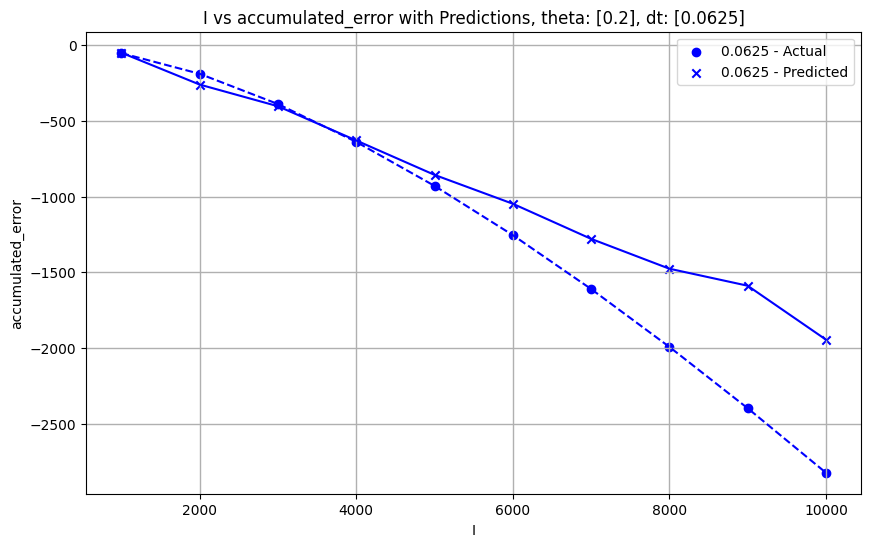

In [273]:
import pandas as pd
import matplotlib.pyplot as plt

df = sampled_err_df.copy()
model = model_poly_final

# Define the filter criteria
filter_criteria = {
    'theta': [0.2],
    'N': [100000],
    # 'I': [10000],
    'dt': [0.0625]
}

# Apply filtering based on the filter criteria
for feature, values in filter_criteria.items():
    df = df[df[feature].isin(values)]

# Add predictions to the filtered dataset
df['predicted_accumulated_error'] = model.predict(df[['N', 'theta', 'dt', 'I']])

# Group by a specific feature
grouped = df.groupby('dt')

# Plot X vs y for each group
colors = ['blue', 'green', 'red', 'purple', 'yellow']  # Specify colors for each group if known

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot X vs y with scatter points and connect them with dashed lines for each group
for (group_name, group_data), color in zip(grouped, colors):
    # Plot actual values
    ax.scatter(group_data['I'], group_data['accumulated_error'], color=color, label=f'{group_name} - Actual')
    ax.plot(group_data['I'], group_data['accumulated_error'], linestyle='--', color=color)  # Dashed line for actual
    
    # Plot predicted values
    ax.scatter(group_data['I'], group_data['predicted_accumulated_error'], color=color, marker='x', label=f'{group_name} - Predicted')
    ax.plot(group_data['I'], group_data['predicted_accumulated_error'], linestyle='-', color=color)  # Solid line for predicted

# Add grid and logarithmic scales
ax.grid(linestyle='-', linewidth=1)
# ax.set_yscale("asinh")         # Logarithmic scale for y-axis

# Add labels, title, and legend
ax.set_xlabel('I')
ax.set_ylabel('accumulated_error')
ax.set_title('I vs accumulated_error with Predictions, theta: [0.2], dt: [0.0625]')
ax.legend()

# Set x and y limits to cover the range of points
# ax.set_xlim(df['I'].min() - 1, df['I'].max() + 1)
# ax.set_ylim(df['accumulated_error'].min() * 0.8, df['accumulated_error'].max() * 1.2)

plt.show()

# COMPARAR CON: https://top500.org/system/179842/
